In [1]:
%cd ..

/fs01/home/abbasgln/codes/medAI/projects/tta


In [2]:
import os
from dotenv import load_dotenv
# Loading environment variables
load_dotenv()

import torch
import torch.nn as nn
import torch.nn.functional as F
import typing as tp
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from dataclasses import dataclass, field
import logging
import wandb

import medAI
from medAI.utils.setup import BasicExperiment, BasicExperimentConfig

from utils.metrics import MetricCalculator

from timm.optim.optim_factory import create_optimizer

from einops import rearrange, repeat
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import timm

from copy import copy, deepcopy
import pandas as pd

from datasets.datasets import ExactNCT2013RFImagePatches, ExactNCT2013RFCores
from medAI.datasets.nct2013 import (
    KFoldCohortSelectionOptions,
    LeaveOneCenterOutCohortSelectionOptions, 
    PatchOptions
)
import torchmetrics



In [3]:
LEAVE_OUT='UVA'

## Data 

In [4]:
###### No support dataset ######

from core_finetune_experiment import CoreFinetuneConfig
config = CoreFinetuneConfig(cohort_selection_config=LeaveOneCenterOutCohortSelectionOptions(leave_out=f"{LEAVE_OUT}"))

from torchvision.transforms import v2 as T

class Transform:
    def __init__(selfT, augment=False):
        selfT.augment = augment
        selfT.size = (256, 256)
        # Augmentation
        selfT.transform = T.Compose([
            T.RandomAffine(degrees=0, translate=(0.2, 0.2)),
            T.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0.5),
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.5),
        ])  
    
    def __call__(selfT, item):
        patches = item.pop("patches")
        patches = copy(patches)
        patches = (patches - np.min(patches, axis=(-2,-1), keepdims=True)) / (np.min(patches, axis=(-2,-1), keepdims=True) - np.min(patches, axis=(-2,-1), keepdims=True)) \
            if config.instance_norm else patches
        patches = torch.tensor(patches).float()
        patches = T.Resize(selfT.size, antialias=True)(patches).float()
        
        label = torch.tensor(item["grade"] != "Benign").long()
        
        if selfT.augment:
            patches_augs = torch.stack([selfT.transform(patches) for _ in range(2)], dim=0)
            return patches_augs, patches, label, item
        
        return -1, patches, label, item


# val_ds = ExactNCT2013RFCores(
#     split="val",
#     transform=Transform(augment=False),
#     cohort_selection_options=config.cohort_selection_config,
#     patch_options=config.patch_config,
#     debug=config.debug,
# )

if isinstance(config.cohort_selection_config, LeaveOneCenterOutCohortSelectionOptions):
    if config.cohort_selection_config.leave_out == "UVA":
        config.cohort_selection_config.benign_to_cancer_ratio = 5.0 
test_ds = ExactNCT2013RFCores(
    split="test",
    transform=Transform(augment=True),
    cohort_selection_options=config.cohort_selection_config,
    patch_options=config.patch_config,
    debug=config.debug,
)


# val_loader = DataLoader(
#     val_ds, batch_size=config.batch_size, shuffle=False, num_workers=0 #, pin_memory=True
# )
test_loader = DataLoader(
    test_ds, batch_size=config.batch_size, shuffle=False, num_workers=0 #, pin_memory=True
)


Computing positions: 100%|██████████| 1902/1902 [00:44<00:00, 42.69it/s]


## Ensemble Model

In [5]:
from baseline_experiment import FeatureExtractorConfig

fe_config = FeatureExtractorConfig()

# Create the model
list_models: tp.List[nn.Module] = [timm.create_model(
    fe_config.model_name,
    num_classes=fe_config.num_classes,
    in_chans=1,
    features_only=fe_config.features_only,
    norm_layer=lambda channels: nn.GroupNorm(
                    num_groups=fe_config.num_groups,
                    num_channels=channels
                    )) for _ in range(5)]

# CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_gn_3ratio_loco/ensemble_5mdls_gn_3ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')
CHECkPOINT_PATH = os.path.join(os.getcwd(), f'logs/tta/ensemble_5mdls_gn_avgprob_3ratio_loco/ensemble_5mdls_gn_avgprob_3ratio_loco_{LEAVE_OUT}/', 'best_model.ckpt')

state = torch.load(CHECkPOINT_PATH)
[model.load_state_dict(state["list_models"][i]) for i, model in enumerate(list_models)]

[model.eval() for model in list_models]
[model.cuda() for model in list_models]

a = True

In [6]:
# # Turn requires_grad off for all layers except the last one
# for model in list_models:
#     for name, params in model.named_parameters():
#         if name != "fc.weight" and name != "fc.bias":
#                 params.requires_grad_(False)
#                 # print(name)
#                 # print(params)
        

## Temp Scaling

In [7]:
temp = 1.0
beta = 0.0
if LEAVE_OUT == "JH":
#     temp = 1.6793
#     beta = -1.0168
    temp = 0.9253
    beta = -1.0273
elif LEAVE_OUT == "PCC":
#     temp = 1.5950
#     beta = -0.8514
    temp = 1.0075
    beta = -0.8614
elif LEAVE_OUT == "PMCC":
#     temp = 0.6312
#     beta = -1.0017
    temp = 0.9020
    beta = -1.0609
elif LEAVE_OUT == "UVA":
#     temp = 0.9333
#     beta = -0.7474
    temp = 1.6528
    beta = -0.6192
elif LEAVE_OUT == "CRCEO":
#     temp = 1.2787
#     beta = -0.8716
    temp = 0.8515
    beta = -0.8461
    
temp = torch.tensor(temp).cuda()
beta = torch.tensor(beta).cuda()

## Run test MEMO

### Separate MEMO

In [ ]:
loader = test_loader
enable_memo = True
certain_threshold = 0.4

from memo_experiment import batched_marginal_entropy
metric_calculator = MetricCalculator()
desc = "test"

criterion = nn.CrossEntropyLoss()

for i, batch in enumerate(tqdm(loader, desc=desc)):
    images_augs, images, labels, meta_data = batch
    images_augs = images_augs[0].cuda().permute(1, 0, 2, 3, 4)
    images = images[0].cuda()
    labels = labels.cuda().repeat(images.shape[0])
    meta_data['pct_cancer'] = meta_data['pct_cancer'].repeat(images.shape[0])
    meta_data['id'] = meta_data['id'].repeat(images.shape[0])
    
    adaptation_model_list = [deepcopy(model) for model in list_models] 
    [model.eval() for model in adaptation_model_list]
    
    if enable_memo:
        batch_size, aug_size= images_augs.shape[0], images_augs.shape[1]

        params = []
        for model in adaptation_model_list:
            params.append({'params': model.parameters()})
        optimizer = optim.SGD(params, lr=5e-4)
        
        _images_augs = images_augs.reshape(-1, *images_augs.shape[2:]).cuda()
        # Adapt to test
        for j in range(1):
            optimizer.zero_grad()
            # Forward pass
            stacked_logits = torch.stack([model(_images_augs).reshape(batch_size, aug_size, -1) for model in adaptation_model_list])
            
            # Remove uncertain samples from test-time adaptation
            certain_idx = F.softmax(stacked_logits, dim=-1).mean(dim=0).mean(dim=1).max(dim=-1)[0] >= certain_threshold
            stacked_logits = stacked_logits[:, certain_idx, ...]
            
            list_losses = []
            list_logits = []
            for k in range(5):
                loss, logits = batched_marginal_entropy(stacked_logits[k,...])
                list_losses.append(loss.mean())
                list_logits.append(logits)
            # Backward pass
            sum(list_losses).backward()
            optimizer.step()
    
    # Evaluate
    logits = torch.stack([model(images) for model in adaptation_model_list])
    losses = [nn.CrossEntropyLoss()(
        logits[i, ...],
        labels
        ) for i in range(5)
    ]
                    
    # Update metrics   
    metric_calculator.update(
        batch_meta_data = meta_data,
        probs = F.softmax(logits, dim=-1).mean(dim=0).detach().cpu(), # Take mean over ensembles
        labels = labels.detach().cpu(),
    )
    

test:   0%|          | 0/608 [00:00<?, ?it/s]

### Combined MEMO

In [ ]:
loader = test_loader_memo
enable_memo = True

from memo_experiment import batched_marginal_entropy
metric_calculator = MetricCalculator()
desc = "test"

criterion = nn.CrossEntropyLoss()

for i, batch in enumerate(tqdm(loader, desc=desc)):
    images_augs, images, labels, meta_data = batch
    images_augs = images_augs.cuda()
    images = images.cuda()
    labels = labels.cuda()
    
    adaptation_model_list = [deepcopy(model) for model in list_models] 
    [model.eval() for model in adaptation_model_list]
    
    if enable_memo:
        batch_size, aug_size= images_augs.shape[0], images_augs.shape[1]

        params = []
        for model in adaptation_model_list:
            params.append({'params': model.parameters()})
        optimizer = optim.SGD(params, lr=5e-4)
        
        _images_augs = images_augs.reshape(-1, *images_augs.shape[2:]).cuda()
        # Adapt to test
        for j in range(1):
            optimizer.zero_grad()
            # Forward pass
            stacked_outputs = torch.stack([model(_images_augs).reshape(batch_size, aug_size, -1) for model in adaptation_model_list])
            
            # for outputs in len(adaptation_model_list):
            #     loss, logits = batched_marginal_entropy(outputs)
            #     list_losses.append(loss.mean())
            #     list_logits.append(logits)
            # # Backward pass
            # sum(list_losses).backward()
            # optimizer.step()
            
            loss, logits = batched_marginal_entropy(stacked_outputs.mean(dim=0))
            # Backward pass
            loss.mean().backward()
            optimizer.step()
    
    # Evaluate
    logits = torch.stack([model(images) for model in adaptation_model_list])
    losses = [nn.CrossEntropyLoss()(
        logits[i, ...],
        labels
        ) for i in range(5)
    ]
                    
    # Update metrics   
    metric_calculator.update(
        batch_meta_data = meta_data,
        probs = F.softmax(logits, dim=-1).mean(dim=0).detach().cpu(), # Take mean over ensembles
        labels = labels.detach().cpu(),
    )

test:   0%|          | 0/726 [00:00<?, ?it/s]

### Get metrrics

In [ ]:
avg_core_probs_first = True
metric_calculator.avg_core_probs_first = avg_core_probs_first

# Log metrics every epoch
metrics = metric_calculator.get_metrics()

# Update best score
(best_score_updated,best_score) = metric_calculator.update_best_score(metrics, desc)

best_score_updated = copy(best_score_updated)
best_score = copy(best_score)
        
# Log metrics
metrics_dict = {
    f"{desc}/{key}": value for key, value in metrics.items()
    }

metrics_dict

{'test/patch_auroc': tensor(0.6415),
 'test/patch_accuracy': tensor(0.8924),
 'test/all_inv_patch_auroc': tensor(0.5996),
 'test/all_inv_patch_accuracy': tensor(0.8724),
 'test/core_auroc': tensor(0.7299),
 'test/core_accuracy': tensor(0.9276),
 'test/all_inv_core_auroc': tensor(0.6740),
 'test/all_inv_core_accuracy': tensor(0.9062)}

## Pseudo labeling

In [9]:
loader = test_loader
enable_pseudo_label = False
temp_scale = False
certain_threshold = 0.4
# certain_radius = torch.tensor(0.15).cuda()
thr = 0.15

metric_calculator = MetricCalculator()
desc = "test"

for i, batch in enumerate(tqdm(loader, desc=desc)):
    images_augs, images, labels, meta_data = batch
    # images_augs = images_augs[0].cuda().permute(1, 0, 2, 3, 4)
    images = images[0].cuda()
    labels = labels.cuda().repeat(images.shape[0])
    meta_data['pct_cancer'] = meta_data['pct_cancer'].repeat(images.shape[0])
    meta_data['id'] = meta_data['id'].repeat(images.shape[0])
    
    adaptation_model_list = [deepcopy(model) for model in list_models] 
    [model.eval() for model in adaptation_model_list]

    
    if enable_pseudo_label:
        params = []
        for model in adaptation_model_list:
            params.append({'params': model.parameters()})
        optimizer = optim.SGD(params, lr=5e-4)
        
        # Adapt to test
        for j in range(2):
            optimizer.zero_grad()
            # Forward pass
            stacked_logits = torch.stack([model(images) for model in adaptation_model_list])
            if temp_scale:
                stacked_logits = stacked_logits / temp + beta
            
            # Remove uncertain samples from test-time adaptation
            certain_idx = F.softmax(stacked_logits, dim=-1).mean(dim=0).max(dim=-1)[0] >= certain_threshold
            # certain_idx = (F.softmax(stacked_logits, dim=-1).mean(dim=0)[:, 1] - torch.tensor(thr).cuda()).abs() >= certain_radius
            stacked_logits = stacked_logits[:, certain_idx, ...]
            
            list_losses = []
            for k, outputs in enumerate(adaptation_model_list):
                loss = nn.CrossEntropyLoss()(stacked_logits[k, ...], (F.softmax(stacked_logits, dim=-1).mean(dim=0)[:, 1] >= thr).to(torch.long))
                list_losses.append(loss.mean())
            # Backward pass
            sum(list_losses).backward()
            optimizer.step()
        
    # Evaluate
    logits = torch.stack([model(images) for model in adaptation_model_list])
    if temp_scale:
        logits = logits / temp + beta
    losses = [nn.CrossEntropyLoss()(
        logits[i, ...],
        labels
        ) for i in range(5)
    ]
                    
    # Update metrics   
    metric_calculator.update(
        batch_meta_data = meta_data,
        probs = F.softmax(logits, dim=-1).mean(dim=0).detach().cpu(), # Take mean over ensembles
        labels = labels.detach().cpu(),
        # raw_probs = F.softmax(logits, dim=-1).detach().cpu(),
    )

test:   0%|          | 0/1886 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
F.softmax(logits, dim=-1).detach().cpu().shape

torch.Size([5, 39, 2])

In [ ]:
avg_core_probs_first = True
metric_calculator.avg_core_probs_first = avg_core_probs_first

# Log metrics every epoch
metrics = metric_calculator.get_metrics()

# Update best score
(best_score_updated,best_score) = metric_calculator.update_best_score(metrics, desc)

best_score_updated = copy(best_score_updated)
best_score = copy(best_score)
        
# Log metrics
metrics_dict = {
    f"{desc}/{key}": value for key, value in metrics.items()
    }

metrics_dict

{'test/patch_auroc': tensor(0.7216),
 'test/patch_accuracy': tensor(0.4960),
 'test/all_inv_patch_auroc': tensor(0.6573),
 'test/all_inv_patch_accuracy': tensor(0.5063),
 'test/core_auroc': tensor(0.7646),
 'test/core_accuracy': tensor(0.4763),
 'test/all_inv_core_auroc': tensor(0.6933),
 'test/all_inv_core_accuracy': tensor(0.4905)}

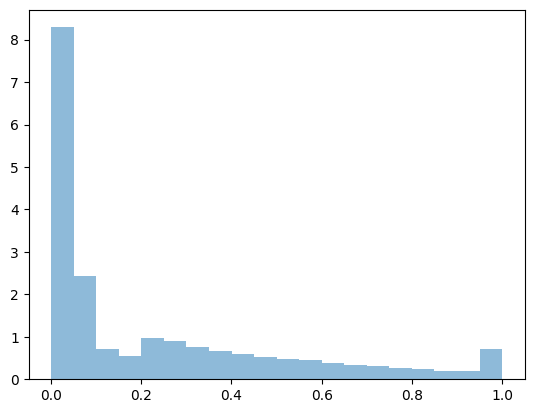

In [ ]:
probs, labels = metric_calculator.get_probs_labels(high_inv=True, core_or_patch="patch")

num_bin = 20
# plt.hist(probs[:, 1][labels==1].numpy(), density=True, bins=num_bin, alpha = 0.5)
# plt.hist(probs[:, 1][labels==0].numpy(), density=True, bins=num_bin,alpha = 0.5)
plt.hist(probs[:, 1].numpy(), density=True, bins=num_bin,alpha = 0.5)
a=True

In [ ]:
thr = 0.15
0.5*(probs[:,1]>=thr)[labels==1].sum()/sum(labels==1) + 0.5*(probs[:,1]<thr)[labels==0].sum()/sum(labels==0)
# probs.argmax(dim=-1).eq(labels).sum()/len(labels)

tensor(0.6365)

## Acc. vs. uncertainty quantile

In [ ]:
thr = 0.22
la=1
probs, labels = metric_calculator.get_probs_labels(high_inv=True, core_or_patch="patch")
# torchmetrics.functional.auroc(probs, labels, task="multiclass", num_classes=2), torchmetrics.functional.accuracy(probs, labels, task="multiclass", num_classes=2)
from utils.metrics import expected_calibration_error, brier_score
# probs_1d = probs[range(len(labels)), labels]
# probs_1d = probs[range(len(labels)), (probs[:,1]>=thr).int()]
probs_1d = probs[range(len(labels)), la]
# brier_score(probs_1d.numpy(), labels.numpy()) 
# ece, output = expected_calibration_error(preds=(probs[:,1]>=thr).numpy(), confidence=probs_1d.numpy(), targets=labels.numpy())
ece, output = expected_calibration_error(preds=(probs[:,1]>=thr)[labels==la].numpy(), confidence=probs_1d[labels==la].numpy(), targets=labels[labels==la].numpy())
ece

0.2726953437319622

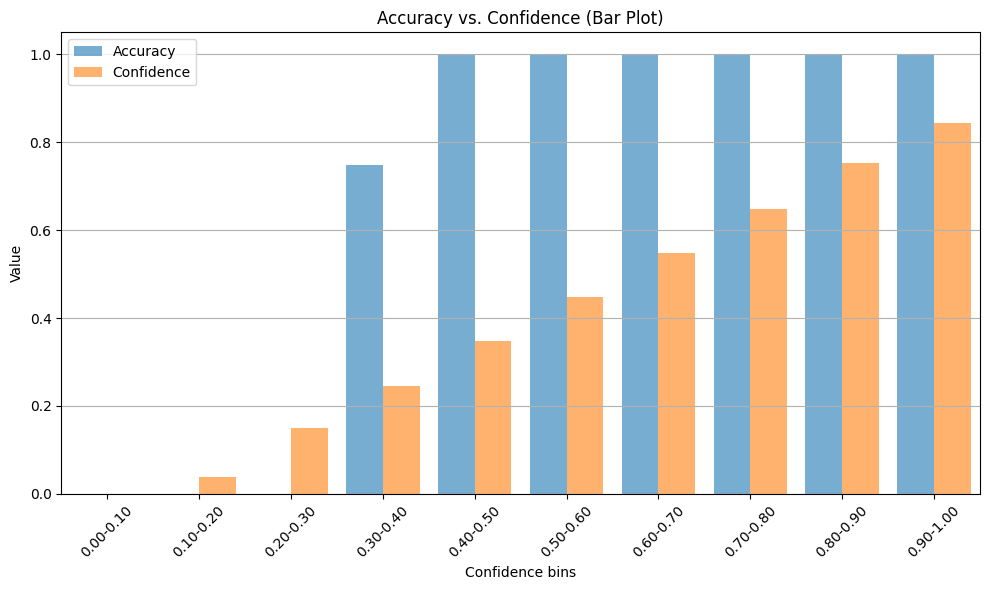

In [ ]:
# Extracting the required information for plotting
acc_by_bin = output["acc_by_bin"]
conf_by_bin = output["conf_by_bin"]
bins = output["bins"]  # Use the bin edges as given by the function

# Calculate the positions for the bars
bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate the center of each bin
width = np.diff(bins)[0] * 0.4  # Width of the bars, adjusted for spacing

# Creating the bar plot
plt.figure(figsize=(10, 6))

# Plot accuracy bars
plt.bar(bin_centers - width/2, acc_by_bin, width=width, label='Accuracy', alpha=0.6)

# Plot confidence bars
plt.bar(bin_centers + width/2, conf_by_bin, width=width, label='Confidence', alpha=0.6)

plt.xlabel('Confidence bins')
plt.ylabel('Value')
plt.title('Accuracy vs. Confidence (Bar Plot)')
plt.legend()

# Adjust x-axis to display bin ranges, fixing the IndexError
plt.xticks(bin_centers, labels=[f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)], rotation=45)
plt.xlim([bins[0], bins[-1]])
plt.grid(True, axis='y')
plt.tight_layout()

plt.show()


## Testing 10% max probs

In [ ]:
## core probs and labels

ids = metric_calculator.remove_low_inv_ids(metric_calculator.core_id_invs)
# ids = list(metric_calculator.core_id_probs.keys())

probs_avg_max = []
for id, probs_list in metric_calculator.core_id_probs.items():
    if id in ids:
        core_len_10th = len(probs_list) // 5 + 1
        probs, labels = torch.stack(probs_list).max(dim=1)
        sorted_probs, indx = probs.sort()
        sorted_probs = sorted_probs[-core_len_10th:]
        indx = indx[-core_len_10th:]
        labels_sorted_probs = labels[indx]
        probs_avg_max.append(sum(sorted_probs*labels_sorted_probs)/core_len_10th)
probs_avg_max = torch.stack(probs_avg_max)

labels = torch.stack(
    [labels_list[0] for id, labels_list in metric_calculator.core_id_labels.items() if id in ids])


In [ ]:
torchmetrics.functional.auroc(probs_avg_max, labels, task="binary"), torchmetrics.functional.accuracy(probs_avg_max, labels, task="binary")

(tensor(0.6683), tensor(0.8987))

## WabdB Log

In [ ]:
import wandb
# group=f"offline_combEnsmPsdo_.8uncrtnty_gn_3ratio_loco"
group=f"offline_combNewCoreEnsmPsdo_0.25thr_.8uncrtn_gn_3ratio_loco"
# group=f"offline_ensemble_avgprob_5mdls_gn_3ratio_loco"
name= group + f"_{LEAVE_OUT}"
wandb.init(project="tta", entity="mahdigilany", name=name, group=group)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: mahdigilany. Use `wandb login --relogin` to force relogin


In [ ]:
metrics_dict.update({"epoch": 0})
wandb.log(
    metrics_dict,
    )
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁
test/all_inv_core_accuracy,▁
test/all_inv_core_auroc,▁
test/all_inv_patch_accuracy,▁
test/all_inv_patch_auroc,▁
test/core_accuracy,▁
test/core_auroc,▁
test/patch_accuracy,▁
test/patch_auroc,▁
epoch,0
test/all_inv_core_accuracy,0.90625
